# Get To The Point: Summarization with Pointer-Generator Networks
Abigail See, Peter J. Liu, Christopher D. Manning `ACL 2017`

https://arxiv.org/pdf/1704.04368.pdf

In [1]:
import os
import re
import sys

from typing import Dict
from typing import List
from typing import Tuple

from collections import defaultdict
from collections import OrderedDict

import matplotlib.pyplot as plt
from IPython.display import Image

import tensorflow as tf
import tensorflow_datasets as tfds

## 0 Setup Sample Examples
Following examples are article and corresponding summary sampled from [CNN/DailyMail summarization dataset](https://www.tensorflow.org/datasets/catalog/cnn_dailymail). Our task is to train a model to generate summary for given article.

In [2]:
BATCH_SIZE = 4
examples, metadata = tfds.load("cnn_dailymail", with_info=True, as_supervised=True)
train_examples, val_examples = examples["train"], examples["validation"]
sample_articles = []
sample_summaries = []
for article, summary in train_examples.take(BATCH_SIZE):
    sample_articles.append(article.numpy().decode("utf-8"))
    sample_summaries.append(summary.numpy().decode("utf-8"))
print("\nSample summaries:\n")
for i, summary in zip(range(BATCH_SIZE), sample_summaries): 
    print(f"[{i}]", repr(summary))


Sample summaries:

[0] 'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'
[1] 'Criminal complaint: Cop used his role to help cocaine traffickers .\nRalph Mata, an internal affairs lieutenant, allegedly helped group get guns .\nHe also arranged to pay two assassins in a murder plot, a complaint alleges .'
[2] "Craig Eccleston-Todd, 27, had drunk at least three pints before driving car .\nWas using phone when he veered across road in Yarmouth, Isle of Wight .\nCrashed head-on into 28-year-old Rachel Titley's car, who died in hospital .\nPolice say he would have been over legal drink-drive limit at time of crash .\nHe was found guilty at Portsmouth Crown Court of causing death by dangerous driving ."
[3] "Nina dos Santos says Europe must be ready to accept sanctions will hurt both sides .\nTargeting Russia's business

### Preprocessing

In [3]:
def PreprocessSentence(sentence: str, max_len: int) -> str:
    """Preprocess an input sentence, make it cosumbale by the model."""
    sentence = sentence.lower().strip()
    sentence = re.sub(r"\s\.\s|\n|\(|\)", r" ", sentence)
    # Add whitespace after certain special characters.
    sentence = re.sub(r"([,.?!$%'])", r" \1 ", sentence)
    # Remove the redundant whitespaces.
    sentence = re.sub(r"[' ']+", " ", sentence)
    # Cap the sentence
    sentence = sentence.split()[:max_len-2]
    sentence = ' '.join((sentence))
    # Add <start> and <end> token to sentence.
    sentence = "<start> " + sentence + " <end>"

    return sentence

In [4]:
MAX_ENC_LEN = 800 # Maximum number of words in the article, including special tokens.
MAX_DEC_LEN = 50  # Maximum number of words in the summary, including special tokens.
sample_articles = [PreprocessSentence(x, MAX_ENC_LEN) for x in sample_articles]
sample_summaries = [PreprocessSentence(x, MAX_DEC_LEN) for x in sample_summaries]
print("\nSample summaries:\n")
for i, summary in zip(range(BATCH_SIZE), sample_summaries): 
    print(f"[{i}]", repr(summary))


Sample summaries:

[0] '<start> bishop john folda , of north dakota , is taking time off after being diagnosed he contracted the infection through contaminated food in italy church members in fargo , grand forks and jamestown could have been exposed . <end>'
[1] '<start> criminal complaint: cop used his role to help cocaine traffickers ralph mata , an internal affairs lieutenant , allegedly helped group get guns he also arranged to pay two assassins in a murder plot , a complaint alleges . <end>'
[2] '<start> craig eccleston-todd , 27 , had drunk at least three pints before driving car was using phone when he veered across road in yarmouth , isle of wight crashed head-on into 28-year-old rachel titley s car , who died in hospital police say he would have been over <end>'
[3] '<start> nina dos santos says europe must be ready to accept sanctions will hurt both sides targeting russia s business community would be one way of sapping their support for president putin , she says but she sa

### Tokenization
Map the article and summary words to their ids. In article OOVs are represented by their temprorary OOV number. For example if the vocab size is 500 and the article has 3 OOVs, then these temporary OOV numbers will be 500, 501, 502.

In [5]:
class Tokenizer(object):
    def __init__(self, 
                 num_words: str=None,
                 oov: str="[OOV]", 
                 special_tokens: List[str]=[],
                 filters: List[str]=[]):
        self.num_words = num_words
        self.oov = oov
        self.special_tokens = set(special_tokens)
        self.word_index = defaultdict()
        self.index_word = defaultdict()
        self.filters = set(filters)
    
    def fit(self, texts: List[str]) -> None:
        word_counts = defaultdict(int)
        for sentence in texts:
            for word in sentence.split():
                if word in self.filters or word in self.special_tokens:
                    continue
                word_counts[word] += 1
        word_counts = sorted(word_counts.items(), 
                             key=lambda x: x[1], 
                             reverse=True)
        index = 1
        
        if self.oov:
            self.word_index[self.oov] = index
            index += 1
        for token in self.special_tokens:
            self.word_index[index] = index
            index += 1
        for word, _ in word_counts:
            if index > self.num_words:
                break
            self.word_index[word] = index
            index += 1
        
        self.index_word = {v: k for k, v in self.word_index.items()}
    
    def word2index(self, word: str) -> int:
        if word not in self.word_index:
            return self.word_index[self.oov]
        return self.word_index[word]
    
    def index2word(self, index: int) -> str:
        if index not in self.index_word:
            return self.oov
        return self.index_word[index]
    
    def article2ids(self, 
                    article: str) -> Tuple[List[int], 
                                           Dict[str, int]]:
        article = article.split()
        ids = []
        oovs = OrderedDict()
        for word in article:
            if (word in self.word_index) and (
                self.word_index[word] <= self.num_words):
                ids.append(self.word2index(word))
            else: 
                if word in oovs:
                    ids.append(oovs[word])
                else:
                    oov_id = self.num_words+len(oovs)+1
                    oovs[word] = oov_id
                    ids.append(oov_id)
        return ids, oovs
    
    def summary2ids(self, 
                    summary: str, 
                    article_oovs: Dict[str, int]) -> List[int]:
        summary = summary.split()
        ids = []
        for word in summary:
            if (word in self.word_index) and (
                self.word_index[word] <= self.num_words):
                ids.append(self.word2index(word))
            elif word in article_oovs:
                ids.append(article_oovs[word])
            else:
                ids.append(self.word_index[self.oov])
        return ids

In [6]:
MAX_VOCAB_SIZE = 300
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, 
                      oov="[OOV]",
                      special_tokens=["<start>", "<end>"])
tokenizer.fit(sample_articles+sample_summaries)
vocab_size = tokenizer.num_words
print(f"Vocab size: {vocab_size}\n")
input_sequences = []
target_sequences = []
max_extended_vocab_size = 0
for article, summary in zip(sample_articles, sample_summaries):
    article_ids, article_oovs = tokenizer.article2ids(article)
    max_extended_vocab_size = max(max(article_oovs.values()), max_extended_vocab_size)
    summary_ids = tokenizer.summary2ids(summary, article_oovs)
    input_sequences.append(article_ids)
    target_sequences.append(summary_ids)
max_extended_vocab_size += 1 # +1 for padding
print(f"Max extended vocab size: {max_extended_vocab_size}\n")    
print(f"Target sequences:\n")
for seq in target_sequences: 
    print(seq)

Vocab size: 300

Max extended vocab size: 524

Target sequences:

[301, 65, 119, 120, 5, 9, 81, 82, 5, 30, 188, 26, 122, 43, 123, 189, 13, 190, 4, 191, 192, 193, 194, 10, 195, 112, 113, 10, 50, 5, 114, 115, 11, 116, 55, 24, 33, 111, 6, 349]
[301, 206, 1, 1, 141, 18, 210, 8, 132, 142, 217, 197, 22, 5, 51, 127, 128, 129, 5, 223, 1, 1, 204, 205, 13, 32, 137, 8, 211, 88, 212, 10, 7, 133, 134, 5, 7, 44, 136, 6, 404]
[301, 144, 29, 5, 145, 5, 28, 93, 16, 100, 149, 150, 90, 23, 58, 14, 53, 34, 74, 13, 241, 242, 97, 10, 162, 5, 153, 9, 154, 244, 94, 75, 256, 57, 59, 12, 58, 5, 46, 99, 10, 267, 31, 293, 13, 27, 24, 33, 89, 433]
[301, 1, 1, 1, 47, 41, 174, 40, 175, 8, 435, 436, 77, 176, 173, 79, 439, 49, 12, 169, 170, 27, 40, 69, 146, 9, 441, 70, 443, 15, 167, 78, 5, 35, 47, 25, 35, 47, 41, 27, 24, 7, 497, 26, 171, 63, 498, 179, 172, 523]


### Padding
Pad the sequences by 0 to get same sequence_length.

In [7]:
def Padding(sequences: List[List[int]], max_len: int) -> List[List[int]]:
    """Pad sequences."""
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences=sequences, maxlen=max_len, padding="post")
    
    return padded

In [8]:
input_sequences = Padding(input_sequences, MAX_ENC_LEN)
max_input_len = len(input_sequences[0])      
target_sequences = Padding(target_sequences, MAX_DEC_LEN)
max_target_len = len(target_sequences[0])
print(f"max_target_len: {max_target_len}")
print(f"\nPadded target sequences:\n")
for seq in target_sequences: print(seq)

max_target_len: 50

Padded target sequences:

[301  65 119 120   5   9  81  82   5  30 188  26 122  43 123 189  13 190
   4 191 192 193 194  10 195 112 113  10  50   5 114 115  11 116  55  24
  33 111   6 349   0   0   0   0   0   0   0   0   0   0]
[301 206   1   1 141  18 210   8 132 142 217 197  22   5  51 127 128 129
   5 223   1   1 204 205  13  32 137   8 211  88 212  10   7 133 134   5
   7  44 136   6 404   0   0   0   0   0   0   0   0   0]
[301 144  29   5 145   5  28  93  16 100 149 150  90  23  58  14  53  34
  74  13 241 242  97  10 162   5 153   9 154 244  94  75 256  57  59  12
  58   5  46  99  10 267  31 293  13  27  24  33  89 433]
[301   1   1   1  47  41 174  40 175   8 435 436  77 176 173  79 439  49
  12 169 170  27  40  69 146   9 441  70 443  15 167  78   5  35  47  25
  35  47  41  27  24   7 497  26 171  63 498 179 172 523]


### Create tfDataset¶

In [9]:
BUFFER_SIZE = 4
dataset = tf.data.Dataset.from_tensor_slices((input_sequences, target_sequences))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
input_sequences, target_sequences = next(iter(dataset))
print("Input sequences: \n", input_sequences)
print("\nTarget sequences: \n", target_sequences)

Input sequences: 
 tf.Tensor(
[[301 125 126 ...   0   0   0]
 [301   7  93 ...  77 107 433]
 [301  37 302 ...   0   0   0]
 [301 125 126 ...   0   0   0]], shape=(4, 800), dtype=int32)

Target sequences: 
 tf.Tensor(
[[301   1   1   1  47  41 174  40 175   8 435 436  77 176 173  79 439  49
   12 169 170  27  40  69 146   9 441  70 443  15 167  78   5  35  47  25
   35  47  41  27  24   7 497  26 171  63 498 179 172 523]
 [301 144  29   5 145   5  28  93  16 100 149 150  90  23  58  14  53  34
   74  13 241 242  97  10 162   5 153   9 154 244  94  75 256  57  59  12
   58   5  46  99  10 267  31 293  13  27  24  33  89 433]
 [301  65 119 120   5   9  81  82   5  30 188  26 122  43 123 189  13 190
    4 191 192 193 194  10 195 112 113  10  50   5 114 115  11 116  55  24
   33 111   6 349   0   0   0   0   0   0   0   0   0   0]
 [301 206   1   1 141  18 210   8 132 142 217 197  22   5  51 127 128 129
    5 223   1   1 204 205  13  32 137   8 211  88 212  10   7 133 134   5
    7  44 136 

## Abstract
Current approaches for abstractive text summarization mainly has two shortcomings: 
 - they are liable to reproduce factual detail inaccurately
 - they are not able to deal with OOV words
 - they tend to repeat themselves
 
The paper proposes a novel architecture that
 - use a seq-to-seq model with **copy mechanism**. This allows the model to copy from source tokens via *pointing*
 - use **coverage mechansim** to penalize repeated attending to the same locations.

## 1 Introduction & Background
there are two broad approaches to summarization:
 - **extractive**: assemble summaries exclusively from passages, taken directly from the source text.
     - copying large chunks of text directly ensures baseline levels of gramaticality and accuracy.
 - **abstractive**: may generate novel words and phrases not featured in the source text.
     - more sophisticated.
     
The recent success of [seq-to-seq](https://arxiv.org/pdf/1409.3215.pdf) models has made abstractive summarization viable:
 - [Abstractive Sentence Summarization with Attentive Recurrent Neural Networks](https://www.aclweb.org/anthology/N16-1012.pdf) Sumit Chopra, Michael Auli, Alexander M. Rush `NAACL 2016`
 - [Abstractive Text Summarization Using Sequence-to-Sequence RNNs and Beyond](https://arxiv.org/pdf/1602.06023.pdf) Ramesh Nallapati, Bowen Zhou, Cicero Nogueira dos santos, Caglar Gulcehre, Bing Xiang `CoNLL 2016`
 - [A Neural Attention Model for Abstractive Sentence Summarization](https://arxiv.org/pdf/1509.00685.pdf) Alexander M. Rush, Sumit Chopra, Jason Weston `EMNLP 2015`
 - [Efficient Summarization with Read-Again and Copy Mechanism](https://arxiv.org/pdf/1611.03382.pdf) Wenyuan Zeng, Wenjie Luo, Sanja Fidler, Raquel Urtasun `2016`
 
However these works exhibit undesirable behavior such as 1) inaccurately reproducing factual details, 2) an inability to deal with out-of-vocabulary (OOV) words, and 3) repeating themselves (see following figure)

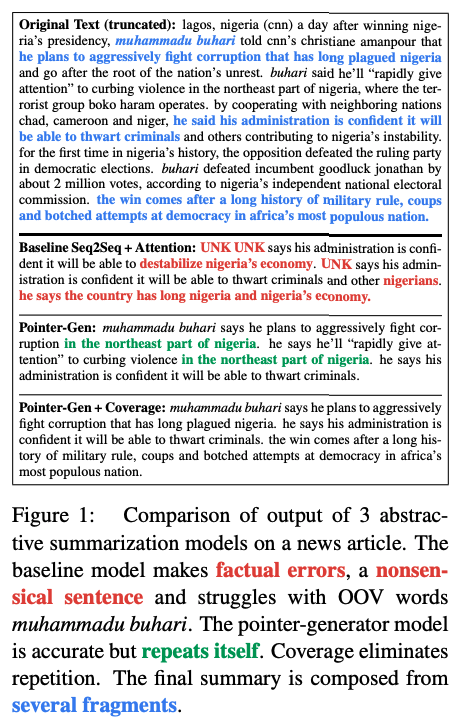

In [10]:
Image(filename='../pics/ptr_gen_example.png')

The paper proposes a ***pointer-generator*** network that
 - allows copying words directly from the source text via *pointing*, which improves the accuracy and handles OOV
     - [Pointer Networks](https://arxiv.org/pdf/1506.03134.pdf) Oriol Vinyals, Meire Fortunato, Navdeep Jaitly `NeurIPS 2015`
 - retain the ability to generate new words

Similar works includes:
 - [Incorporating Copying Mechanism in Sequence-to-Sequence Learning](https://arxiv.org/pdf/1603.06393.pdf) Jiatao Gu, Zhengdong Lu, Hang Li, Victor O.K. Li `ACL 2016`
 - [Language as a Latent Variable: Discrete Generative Models for Sentence](https://arxiv.org/pdf/1609.07317.pdf) Yishu Miao, Phil Blunsom `EMNLP 2016`
 
This work is different in the way that this work:
 - calculates an explicit switch probability $p_{gen}$, where as Gu et al. induce competition through a shared softmax.
 - recycles the attention distribution to serve as the copy distribution, but Gu et al. use two separate distributions.
 - sum probability mass from all corresponding parts of the attention when a word appears multiple times in the source text, whereas Miao et al. do not.
 
To resolve the issue of repetiveness, the paper proposes a novel variant of the **coverage vector**, to track and control the coverage of the source document.
 - [Modeling Coverage for Neural Machine Translation](https://arxiv.org/pdf/1601.04811.pdf) Zhaopeng Tu, Zhengdong Lu, Yang Liu, Xiaohua Liu, Hang Li `ACL 2016`

## 2 Model Architecture

Papers proposes a seq-to-seq attentional model with a single layer bi-directional LSTM encoder, a single layer uni-directional LSTM decoder, with the Bahdanau attention. More details could be found in our paper review or the original paper:
 - [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf) Dzmitry Bahdanau, Kyunghyun Cho, Yoshua Bengio `ICLR 2015`

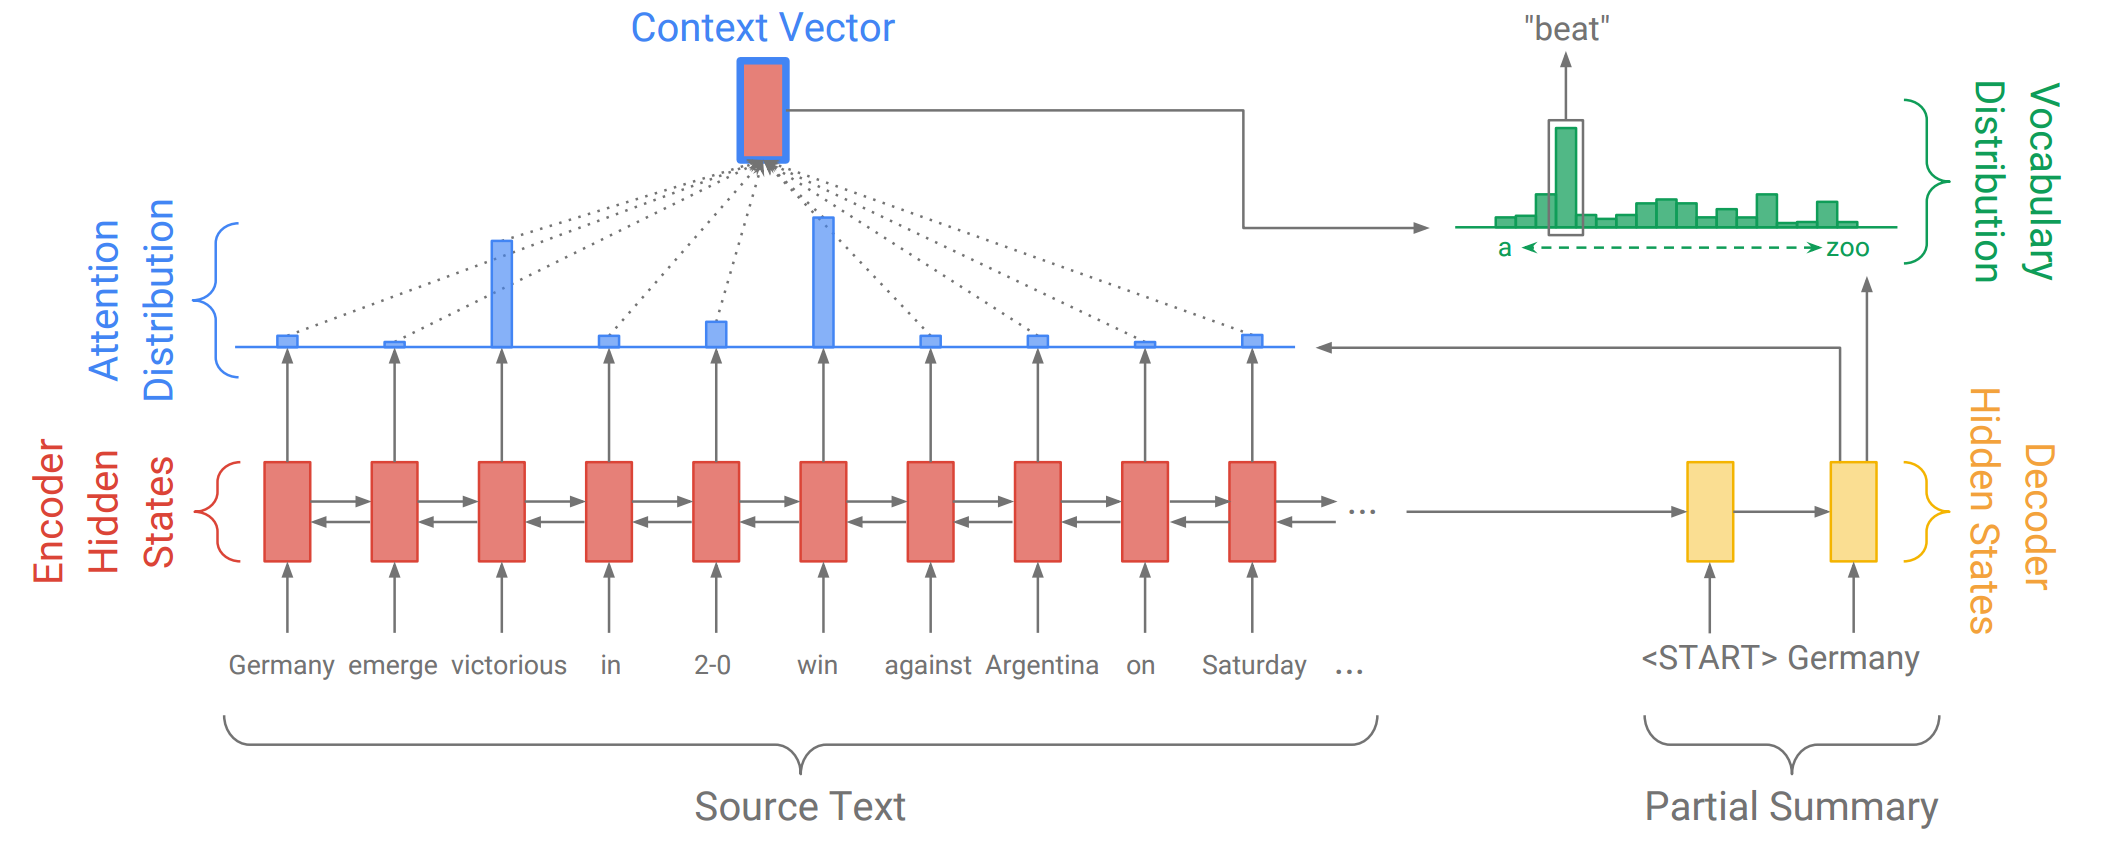

In [11]:
Image(filename='../pics/ptr_gen_net.png')

### 2.1 Encoder

The encoder uses a bi-directional LSTM, returns a collection of hidden vectors $\{h_j\}$ where $i$ is the $i$th token, the final step hidden and final step memory. 

In the paper `emb_size=128`, `hidden_size=256`

In [12]:
def Encoder(extended_vocab_size: int, 
            emb_size: int, 
            hidden_size: int,
            max_enc_len: int, 
            name: str="encoder"):
    """Bi-directional LSTM encoder.

    Args:
        extended_vocab_size: Size of the extended vocab.
        emb_size: Dimensionality of the embeddings.
        hidden_size: Dimensionality of the layers.
        max_enc_len: Maximum number of encoding steps.
        name: Name of the Encoder.
    Inputs:
        input_sequences: Indices of input sequence tokens, of shape 
            (batch_size, max_enc_len)
    Returns:
        input_encodings: encoded input sequence (batch_size, max_enc_len, hidden_size)
        final_state: final encoder state, of shape (batch_size, hidden_size)
    """
    input_sequences = tf.keras.Input(shape=(max_enc_len, ), name="input_sequences")
    embedding_layer = tf.keras.layers.Embedding(input_dim=extended_vocab_size, 
                                                output_dim=emb_size)
    bi_lstm_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=hidden_size, 
                            return_sequences=True,
                            return_state=True))
    reduce_states = tf.keras.layers.Dense(hidden_size)
    reduce_memory = tf.keras.layers.Dense(hidden_size)
    
    # Embedding layer. (batch_size, max_enc_len, emb_size)
    embeddings = embedding_layer(input_sequences)
    # Bi-GRU layer. 
    #  - input_encodings: (batch_size, max_enc_len, hidden_size*2)
    #  - forward_state: (batch_size, hidden_size)
    #  - backward_state: (batch_size, hidden_size)
    input_encodings, final_forward_state, _, final_backward_state, _ = bi_lstm_layer(embeddings)
    # Reduce the forward and backward memory/state into a single initial state for the 
    # decoder since decoder is not Bi-directional. (batch_size, hidden_size)
    final_state = reduce_states(tf.concat([final_forward_state, final_backward_state], axis=1))
    
    return tf.keras.Model(
      inputs=[input_sequences], outputs=[input_encodings, final_state], name=name)

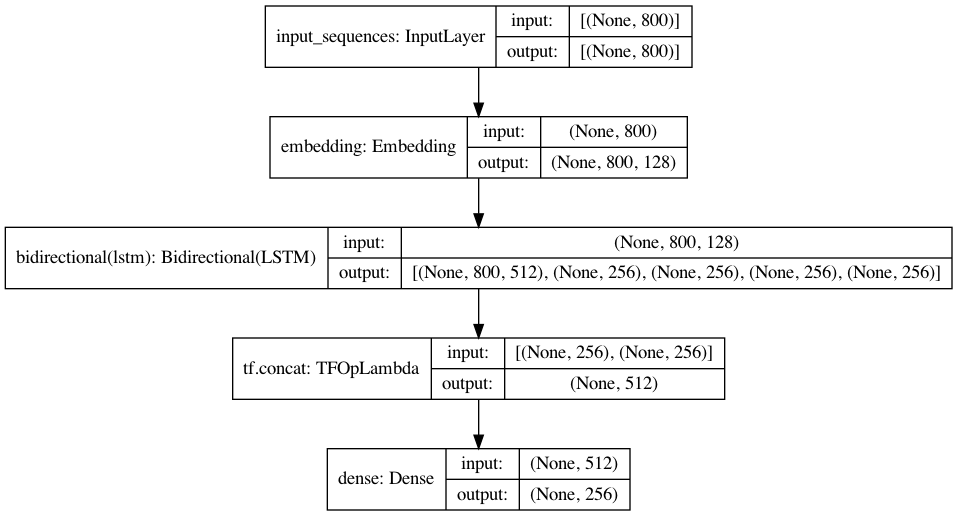

In [13]:
# Example
EMB_SIZE = 128
HIDDEN_SIZE = 256
encoder = Encoder(extended_vocab_size=max_extended_vocab_size,
                  emb_size=EMB_SIZE, 
                  hidden_size=HIDDEN_SIZE, 
                  max_enc_len=MAX_ENC_LEN)
input_encodings, final_encoder_state = encoder(input_sequences)
tf.keras.utils.plot_model(encoder, show_shapes=True)

### 2.2 Masking
#### Padding mask
Mask all the pad tokens in the batch of sequences, to make sure the model doesn't treat paddings as inputs.

In [14]:
def GetPaddingMask(sequences: tf.Tensor) -> tf.Tensor:
    """ Create padding mask.
    
    Args:
        sequences: input sequences, of shape (batch_size, seq_len)
    Returns:
        mask: mask tensor of shape (batch_size, seq_len)
    """
    mask = tf.cast(tf.not_equal(sequences, tf.constant(0)), tf.float32)
    
    return mask

In [15]:
# Example
input_padding_mask = GetPaddingMask(input_sequences)
print("Input padding mask:")
print(input_padding_mask)

Input padding mask:
tf.Tensor(
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]], shape=(4, 800), dtype=float32)


### 2.3 Bahdanau Attention

For timestep $i$, given $s_{i-1}$ is the hidden state from previous decoding step and $h=\{h_j\}$ are encoder outputs

The attention is calculated in three steps:

- **Score** Q (hidden state in previous decoding steps) and K (encoder outputs)

$$e_{ij}=W_a\tanh(W_ss_{t-1}+W_hh+b_{attn}))$$

- **Aignment** with softmax to get attention weights

$$\alpha_{ij}=\frac{exp(e_{ij})}{\sum_{k=1}^{T_X}exp(e_{ik})}$$

- **Calculate Attention** as weighted sum of V (encoder outputs)

$$c_i=\sum_{j=1}^{T_x}\alpha_{ij}h_j$$

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    """ Bahdanau attention layer.
    
    Args:
        hidden_size: Dimensionality of the layers.
        name: Name of the layer.
    Inputs:
        inputs: A dict of tensor
            - query: The query tensor of shape (batch_size, hidden_size)
            - values: The query tensor of shape (batch_size, max_enc_len, hidden_size*2)
            - input_padding_mask: The mask tensor of shape (batch_size, max_enc_len)
    Returns:
        context_vector: of shape (batch_size, hidden_size)
        attention_weights: of shape (batch_size, max_enc_len)
    """
    def __init__(self, hidden_size: int, name: str="attention"):
        super(BahdanauAttention, self).__init__(name=name)
        self.query_linear = tf.keras.layers.Dense(units=hidden_size)
        self.value_linear = tf.keras.layers.Dense(units=hidden_size)
        self.score_linear = tf.keras.layers.Dense(units=1)
        
    def call(self, inputs: Dict[str, tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
        query = inputs["query"]
        values = inputs["values"]
        input_padding_mask = inputs["input_padding_mask"]
        
        # Calculate Q tensor of shape (batch_size, 1, hidden_size)
        q = self.query_linear(tf.expand_dims(query, 1))
        # Calcualte V tensor of shape (batch_sizem, max_enc_len, hidden_size)
        v = self.value_linear(values)
        
        # Attention - Score (Additive attention), of shape (batch_size, max_enc_len, 1)
        score = self.score_linear(tf.nn.tanh(q+v))
        # Attention - Alignment
        #  - Softmax on the second axis (max_enc_len) so that the scores add up to 1.
        attention_weights = tf.nn.softmax(score, axis=1)
        #  - Mask the paddings in encoder sequence so their are not included in the attentions.
        #    Rescale the attention_weights to exclude the effect of paddings.
        input_padding_mask = tf.expand_dims(input_padding_mask, axis=-1)
        attention_weights *= tf.cast(input_padding_mask, tf.float32)
        attention_weights /= tf.expand_dims(tf.reduce_sum(attention_weights, axis=1), -1)
        # Attention - Calculate context vector, of shape (batch_size, 1, hidden_dim)
        context_vector = attention_weights * v
        context_vector = tf.reduce_sum(context_vector, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=-1)
        
        return context_vector, attention_weights

In [17]:
# Example
attention = BahdanauAttention(hidden_size=HIDDEN_SIZE)
context_vector, attention_weights = attention({"query": final_encoder_state, 
                                               "values": input_encodings, 
                                               "input_padding_mask": input_padding_mask})
print("Context vector:")
print(context_vector)
print("\nattention weights:")
print(attention_weights)

Context vector:
tf.Tensor(
[[-0.00019369 -0.00076921  0.00113609 ...  0.0018121   0.00113054
   0.00120288]
 [-0.00128097 -0.00034139  0.00155877 ...  0.00068914  0.00083087
  -0.00071549]
 [ 0.0008994  -0.00018521  0.00256606 ...  0.00103869  0.00336624
   0.00238887]
 [-0.00103003 -0.00085442  0.00199222 ...  0.00031905  0.0017433
   0.00030176]], shape=(4, 256), dtype=float32)

attention weights:
tf.Tensor(
[[0.00169103 0.00170045 0.00171668 ... 0.         0.         0.        ]
 [0.00124197 0.00124377 0.00125103 ... 0.00125954 0.00123949 0.00123684]
 [0.00483837 0.00485087 0.0048366  ... 0.         0.         0.        ]
 [0.00224956 0.0022632  0.00228578 ... 0.         0.         0.        ]], shape=(4, 800), dtype=float32)


### 2.4 Coverage Mechanism (optional)

The mechanism maintains a *coverage vector* $cov_i$ and updates it after each timestep $i$ by adding the latest attention weights $\alpha_i$

$$cov_t=\sum_{i=0}^{t-1}\alpha_i=cov_{t-1}+\alpha_{t-1}$$

This will change the **Score** step to

$$e_{ij}=W_a\tanh(W_ss_{t-1}+W_hh+W_{cov}cov_{t-1}+b_{attn}))$$

Additionally a *coverage loss* is used to penalize repeatedly attending to the same locations

$$covloss_i=\sum_j\min(\alpha_{ij}, cov_{ij})$$

### 2.5 Decoder

At decoding step $j$, the generation probability $p_{gen}\in[0, 1]$ is calculated as

$$p_{gen}=\sigma(W_c^Tc_j+W_s^Ts_{j}+W_y^Ty_{j-1}+b_{ptr})$$

The vocabulary distribution $P_{vocab}$ is calculated as:

$$P_{vocab}=softmax(W_2(W_1[s_j,c_j])+b_2)$$

For each document let the **extended vocab** denote the union of the vocabulary, and all source tokens. The distribution over the extended vocab is:

$$P(w)=p_{gen}P_{vocab}(w)+(1-p_{gen})\sum_ia_{ij}$$

Where $c_j$ is the context vector of current step, $s_{j}$ is the decoder output of current step, $y_{j-1}$ is the target token of previous step, $\{a_ij\}$ are attention weights.

In [19]:
def Decoder(extended_vocab_size: int, 
            emb_size: int, 
            hidden_size: int,
            max_enc_len: int, 
            max_dec_len: int, 
            name: str="decoder"):
    """LSTM decoder.
    
    Args:
        extended_vocab_size: Size of the extended vocab.
        emb_size: Dimensionality of the embeddings.
        hidden_size: Dimensionality of the layers.
        max_enc_len: Maximum number of encoding steps
        max_dec_len: Maximum number of decoding steps.
        name: Name of the Decoder.
    Inputs:
        input_sequences: Indices of input sequence tokens, of shape 
            (batch_size, max_enc_len)
        input_encodings: Encoded input sequences, of shape 
            (batch_size, max_enc_len, hidden_size*2)
        target_sequences: Indices of target sequence tokens, of shape 
            (batch_size, max_dec_len)
        final_encoder_state: Final state of the encoder, of shape
            (batch_size, hidden_size)
        input_padding_mask: The mask tensor of shape (batch_size, max_enc_len)
    Returns:
        decoder_output: of shape (batch_size, max_dec_len, extended_vocab_size)
    """
    input_sequences = tf.keras.Input(shape=(max_enc_len, ), dtype=tf.int32, name="input_sequences")
    input_encodings = tf.keras.Input(shape=(max_enc_len, hidden_size*2, ), name="input_encodings")
    target_sequences = tf.keras.Input(shape=(max_dec_len, ), name="target_sequences")
    final_encoder_state = tf.keras.Input(shape=(hidden_size, ), name="final_encoder_state")
    input_padding_mask = tf.keras.Input(shape=(max_enc_len, ), name="input_padding_mask")
    
    embedding_layer = tf.keras.layers.Embedding(input_dim=extended_vocab_size, 
                                                output_dim=emb_size)
    attention_layer = BahdanauAttention(hidden_size=hidden_size)
    lstm_cell = tf.keras.layers.LSTMCell(units=hidden_size)
    p_gen_linear = tf.keras.layers.Dense(units=1, activation="sigmoid")
    p_vocab_linear1 = tf.keras.layers.Dense(units=hidden_size)
    p_vocab_linear2 = tf.keras.layers.Dense(units=extended_vocab_size, 
                                            activation="softmax")
    
    # Embedding layer. (batch_size, max_dec_len, emb_size)
    embeddings = embedding_layer(target_sequences)
    
    # Create indices from input_sequences. This is used to project the copy distribution
    # The first integer is the batch number, the second integet is the extended vocab index
    # e.g. [[0, 1], [0, 27], [0, 36], [1, 18], [1, 9], [1, 45]]
    batch_size = tf.shape(input_sequences)[0]
    batch_nums = tf.expand_dims(tf.range(0, limit=batch_size), 1)
    batch_nums = tf.tile(batch_nums, [1, max_enc_len])
    indices = tf.stack([batch_nums, input_sequences], axis=2)
    
    # Initialize LSTM states. (batch_size, hidden_size)
    hidden_state = final_encoder_state
    cell_state = tf.zeros_like(hidden_state)
    
    decoder_output = []
    for t in range(max_dec_len):
        token_embedding = embeddings[:, t, :]
        # Attention
        #  - context_vector of shape (batch_size, hidden_size)
        #  - attention_weights of shape (batch_size, max_enc_len)
        context_vector, attention_weights = attention_layer({"query": hidden_state,
                                                             "values": input_encodings, 
                                                             "input_padding_mask": input_padding_mask})
        
        # Concat context vector and embedding, of shape (batch_size, 1, hidden_size + emb_size)
        lstm_input = tf.concat([context_vector, token_embedding], axis=-1)
        # Update the hidden_state and cell_state with a single LSTM cell.
        _, (hidden_state, cell_state) = lstm_cell(inputs=lstm_input, 
                                                  states=[hidden_state, cell_state])
        
        # Calcualte p_gen with a linear layer + sigmoid. (batch_size, 1)
        p_gen_input = tf.concat([context_vector, hidden_state, token_embedding], axis=-1)
        p_gen = p_gen_linear(p_gen_input)
        
        # Calcualte vocab distribution with two linear layers + softmax (batch_size, extended_vocab_size)
        # (Not sure why two linear layers are needed. When there's no activation function, one linear
        #  will ends up be absorted by one another.)
        vocab_dist_input = tf.concat([hidden_state, context_vector], axis=-1)
        vocab_dist = p_vocab_linear2(p_vocab_linear1(vocab_dist_input))   

        # Calculate copy distribution. 
        copy_dist = tf.scatter_nd(indices=indices, 
                                  updates=attention_weights, 
                                  shape=[batch_size, extended_vocab_size])

        # Calculate mixed distribution over extended vocab.
        p = p_gen*vocab_dist + (1-p_gen)*copy_dist
        decoder_output.append(p)

    decoder_output = tf.stack(decoder_output, axis=1)

    return tf.keras.Model(
      inputs=[input_sequences, target_sequences, input_encodings, final_encoder_state, input_padding_mask], 
        outputs=decoder_output, name=name)

In [21]:
# Example
decoder = Decoder(extended_vocab_size=max_extended_vocab_size,
                  emb_size=EMB_SIZE, 
                  hidden_size=HIDDEN_SIZE, 
                  max_enc_len=MAX_ENC_LEN, 
                  max_dec_len=MAX_DEC_LEN)
decoder_output = decoder([input_sequences, 
                          target_sequences, 
                          input_encodings, 
                          final_encoder_state, 
                          input_padding_mask])
print(decoder_output)

tf.Tensor(
[[[0.00094455 0.00094451 0.00095007 ... 0.00182042 0.00182243 0.00182784]
  [0.00095779 0.00095555 0.00096039 ... 0.00182397 0.0018262  0.0018292 ]
  [0.00095873 0.00095608 0.00095946 ... 0.00182582 0.001828   0.00182995]
  ...
  [0.00096153 0.00095694 0.0009607  ... 0.00181693 0.00182411 0.00183386]
  [0.00095354 0.00095007 0.0009512  ... 0.00181613 0.00182067 0.00183455]
  [0.00096652 0.00095734 0.00096068 ... 0.00181569 0.00182172 0.00183449]]

 [[0.0009449  0.00094416 0.0009488  ... 0.00094382 0.00094541 0.00094789]
  [0.0009661  0.00096153 0.0009711  ... 0.00096606 0.00096572 0.00097045]
  [0.0009759  0.00097315 0.00097655 ... 0.00097331 0.00097317 0.00097848]
  ...
  [0.0009697  0.00096655 0.00097171 ... 0.000969   0.0009743  0.0009778 ]
  [0.00095096 0.00094679 0.00095707 ... 0.00095229 0.0009508  0.00095341]
  [0.00096315 0.0009615  0.00096813 ... 0.00096409 0.00096391 0.00096531]]

 [[0.00094393 0.00094399 0.00094978 ... 0.00094643 0.00094226 0.00094451]
  [0.000945